In [1]:
%run common_imports.py

%matplotlib qt
%config InlineBackend.figure_format = 'retina'
sns.set_context("talk")

%reload_ext autoreload
%autoreload 2
pd.options.display.max_rows = 600
pd.set_option('display.float_format', lambda x: '%.9f' % x)

dj.config['display.limit'] = 10**3  

os.environ["SPYGLASS_USE_TRANSACTIONS"] = "1"  
os.environ['KACHERY_API_KEY'] = "RhysjLwgmBAt2ObCyXXaDnqAv2kTdYRa"

import sys
import notebooks.sorting_multiprocessing as smp
import spyglass.spikesorting.v1 as sgs
import spikeinterface as si
import spikeinterface.widgets as sw
import spikeinterface.core as sc
import spyglass.position.v1 as sgp
import spyglass.linearization.v1 as sgpl

from spyglass.position import PositionOutput
from spyglass.spikesorting.analysis.v1.group import UnitSelectionParams
from spyglass.spikesorting.analysis.v1.group import SortedSpikesGroup
from notebooks.trial_extraction import *
from spyglass.spikesorting.spikesorting_merge import SpikeSortingOutput
from notebooks.spike_analysis import *

[2025-12-13 12:23:07,687][INFO]: Connecting anirudh@172.16.102.154:3306
[2025-12-13 12:23:07,708][INFO]: Connected anirudh@172.16.102.154:3306


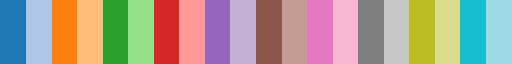

In [2]:
from cycler import cycler
cmap = 'tab20'
n_colors = 6
cmap = plt.get_cmap(cmap)
colors = [cmap(i) for i in np.linspace(0,1,n_colors)]
plt.rcParams["axes.prop_cycle"] = cycler(color = colors)
cmap

In [3]:
graph = sgpl.TrackGraph() & {"track_graph_name":"Wtrack_J1620210722"}

### Plot unit-wise spiking locations

#### Fetch spikes

In [ ]:
sorter_keys = {
    "nwb_file_name": nwb_copy_file_name,
    "sorter": "mountainsort4",
    "curation_id": 2,
}

pfc_merge_ids = SpikeSortingOutput().get_restricted_merge_ids(sorter_keys, restrict_by_artifact = True)

keys = [{"merge_id": merge_id} for merge_id in pfc_merge_ids]
(SpikeSortingOutput.CurationV1 & keys)

In [ ]:
# get spikes from a specific group
group_key = {
    "nwb_file_name": nwb_copy_file_name,
    "sorted_spikes_group_name": "epoch 2 mPFC",
}

SortedSpikesGroup().Units & group_key
group_key = (SortedSpikesGroup & group_key).fetch1("KEY")

pfc_e2_spikes = SortedSpikesGroup().fetch_spike_data(group_key)


#### Fetch position

In [ ]:
epoch = 2
dlc_centroid_params_name = "nose_tail_no_nan"
pos_key = {
    "nwb_file_name": nwb_copy_file_name,
    "epoch": f"{epoch}", 
    "dlc_model_params_name": "WtrackSep5",
    "dlc_centroid_params_name": dlc_centroid_params_name  
}

merge_id = (PositionOutput.DLCPosV1() & pos_key).fetch1("merge_id")

#### Plot

In [ ]:
centroid_position = (PositionOutput() & {"merge_id": merge_id}).fetch1_dataframe()

In [ ]:
# Single unit firing across all positions
unit = 8
spike_times = pfc_e2_spikes[unit]
spike_positions = np.searchsorted(centroid_position.index.tolist(), spike_times)
fig,ax = plt.subplots(layout = "tight")
ax.scatter(centroid_position.position_x, centroid_position.position_y, s = 4, color = 'k', alpha = 0.03)
ax.scatter(centroid_position.position_x.iloc[spike_positions], centroid_position.position_y.iloc[spike_positions], color = "#1188d8", s = 4, label = "spikes")
plt.legend();

### Extract trials

In [ ]:
def get_centroid_and_linear_position(epoch: int,
                                     dlc_si_cohort_centroid: str = "nose_tail_no_nan",
                                     linearization_param_name: str = "default"):
    merge_id = (PositionOutput.DLCPosV1() & {"epoch": epoch, "dlc_si_cohort_centroid": dlc_si_cohort_centroid}).fetch1("merge_id")
    centroid_df = (PositionOutput & {"merge_id": merge_id}).fetch1_dataframe()
    
    pos_merge_id = (PositionOutput.DLCPosV1() & {"dlc_si_cohort_centroid": dlc_si_cohort_centroid, "epoch": epoch}).fetch1("merge_id")
    linear_df =(sgpl.LinearizedPositionV1() & {"pos_merge_id":pos_merge_id, "linearization_param_name": linearization_param_name}).fetch1_dataframe()
    
    return centroid_df, linear_df

In [ ]:
epoch2_centroid_df, epoch2_linear_df = get_centroid_and_linear_position(epoch=2)
epoch4_centroid_df, epoch4_linear_df = get_centroid_and_linear_position(epoch=4)
epoch6_centroid_df, epoch6_linear_df = get_centroid_and_linear_position(epoch=6)
epoch8_centroid_df, epoch8_linear_df = get_centroid_and_linear_position(epoch=8)


In [ ]:
#get lick evenets and trial events
lick_events_df = prepare_DIO_data(session_restriction=session_restrict, lick_event_threshold=2)
trials_df = prepare_trial_data(lick_events_df)

In [ ]:
#merge position information with all trials
target = pd.concat([epoch2_centroid_df, epoch2_linear_df], axis = 1)
e2_trialized_position = merge_trial_df_with_target(target, trials_df)

target = pd.concat([epoch4_centroid_df, epoch4_linear_df], axis = 1)
e4_trialized_position = merge_trial_df_with_target(target, trials_df)

In [ ]:
trialized_position = e2_trialized_position.copy()

In [ ]:
# Plot trajectory for a single trial
trial = 1

t_start = trials_df.loc[trials_df["trial_number"] == trial, "trial_start"].iloc[0]
t_end = trials_df.loc[trials_df["trial_number"] == trial, "trial_end"].iloc[0]

# build boolean mask and select rows between the timestamps
mask = (epoch2_centroid_df.index > t_start) & (epoch2_centroid_df.index < t_end)
fig, ax = plt.subplots(layout = 'tight')
plot_background_position(epoch2_centroid_df, ax)
epoch2_centroid_df.loc[mask].plot.scatter(x = "position_x", y = "position_y", s = 8, ax = ax, c = epoch2_centroid_df.loc[mask].index, cmap = "Blues")

In [ ]:
#plot various phases of a task
trial = 24
mask_reward = (e2_trialized_position["trial_number"] == trial) & (e2_trialized_position["zone"] == "reward")
mask_run = (e2_trialized_position["trial_number"] == trial) & (e2_trialized_position["zone"] == "run")
mask_turn = (e2_trialized_position["trial_number"] == trial) & (e2_trialized_position["zone"] == "turn")

fig, ax = plt.subplots(figsize = (15, 12), layout = "tight")
plot_background_position(e2_trialized_position, ax)
e2_trialized_position[mask_reward].plot.scatter(x = "position_x", y = "position_y", ax = ax, color = "green")
e2_trialized_position[mask_turn].plot.scatter(x = "position_x", y = "position_y", ax = ax, color = "yellow")
e2_trialized_position[mask_run].plot.scatter(x = "position_x", y = "position_y", ax = ax, color = "red");

### Behavior

In [ ]:
#Incorrect trial numbers
pd.unique(trialized_position[trialized_position["trial_label"]=="error"]["trial_number"])

In [ ]:
#plot single trial trajectory and speed 
trial = 18
mask = trialized_position["trial_number"]==trial
timestamps = trialized_position[mask].index - trialized_position[mask].index.tolist()[0]
with plt.style.context("dark_background"):
    fig, ax = plt.subplots(1, 2, layout = "tight", figsize = (20, 10))
    plot_background_position(trialized_position, ax[0], background_color="white")
    trialized_position[mask].plot.scatter(x = "position_x", y = "position_y", ax = ax[0], c = "speed", s = 20, vmin = 0, vmax = 80)
    ax[1].plot(timestamps, trialized_position[mask]["speed"])

### Spingle unit spikes/behavior tuning

In [7]:
def fetch_single_epoch_spikes(nwb_file_name: str,
                              sorted_spikes_group_nane: str):
    group_key = {
        "nwb_file_name": nwb_file_name,
        "sorted_spikes_group_name": sorted_spikes_group_nane
    }
    
    SortedSpikesGroup.Units & group_key
    
    group_key = (SortedSpikesGroup & group_key).fetch1("KEY")
    return SortedSpikesGroup().fetch_spike_data(group_key)

In [ ]:
epoch2_mpfc_spikes = fetch_single_epoch_spikes(nwb_file_name=nwb_copy_file_name, sorted_spikes_group_nane="epoch 2 mpfc")
epoch4_mpfc_spikes = fetch_single_epoch_spikes(nwb_file_name=nwb_copy_file_name, sorted_spikes_group_nane="epoch 4 mpfc")
epoch6_mpfc_spikes = fetch_single_epoch_spikes(nwb_file_name=nwb_copy_file_name, sorted_spikes_group_nane="epoch 6 mpfc")
epoch8_mpfc_spikes = fetch_single_epoch_spikes(nwb_file_name=nwb_copy_file_name, sorted_spikes_group_nane="epoch 8 mpfc")


#### Rest vs run

In [ ]:
mean_fr_df = rest_vs_run_firing_rates(epoch2_mpfc_spikes, trialized_position[ (trialized_position["track_segment_id"]==2)]
                                      , speed_threshold=5, segment_threshold=3)
plot_rest_vs_run_fr(mean_fr_df)


#### Speed tuning

In [ ]:
# speed tuning for select units
spikes_list = epoch2_mpfc_spikes.copy()
# units = np.arange(0, len(spikes_list))
units = [0, 2, 5]
spikes_list = [spikes_list[i] for i in units]
zone = "run"
trial_type = "outbound"
mask =  (trialized_position["zone"]==zone)\
        & (trialized_position["trial_type"] == f"{trial_type}") \
          & (trialized_position["track_segment_id"]==2) \
           #     | (trialized_position["track_segment_id"]==4))


position_tuning, position_bin_centers = compute_tuning(
    trialized_position,  # full df
    "speed",
    spikes_list,
    n_bins=8,
    mask=mask,
)

# # plot_speed_tuning_heatmap(speed_tuning)

plot_tuning_grid(position_tuning, "speed", trialized_position, spikes_list, mask, n_units = 33, label = f"({zone}; {trial_type})")
# plot_position_tuning_grid(position_tuning, trialized_position, spikes_list, mask, n_units = -1, label = f"entire epoch")


In [ ]:
#plot single unit spikes: rest vs run
unit = 2

mask_stat = trialized_position["speed"]<5
mask_running = trialized_position["speed"]>5


spike_idx = np.searchsorted(trialized_position.index.tolist(), spikes_list[unit][spikes_list[unit]>trialized_position.index[0]])
spike_idx_stat = np.searchsorted(trialized_position[mask_stat].index.tolist(), spikes_list[unit])
spike_idx_running = np.searchsorted(trialized_position[mask_running].index.tolist(), spikes_list[unit])
fig, ax = plt.subplots(layout = "tight")
plot_background_position(trialized_position, ax)
ax.scatter(trialized_position.position_x.iloc[spike_idx_stat], trialized_position.position_y.iloc[spike_idx_stat], s = 10, color = "y", label = "speed < 3 cm/s")
ax.scatter(trialized_position.position_x.iloc[spike_idx_running], trialized_position.position_y.iloc[spike_idx_running], s = 10, color = "r", label = "speed > 3 cm/s")
plt.legend()

#### Direction tuning

In [ ]:
# Positional restriction: only track_segment_id == 2

#OUTBOUND VS INBOUND 
pos_df = trialized_position[(trialized_position["zone"] == "run")].copy()
arms = [2]
last_trial = 31

pos_mask_outin = (pos_df["track_segment_id"].isin(arms))

summary_outin , trial_outin  = compute_trialwise_firing_rates_two_trial_categories_with_pos_mask(
    spikes_list=epoch2_mpfc_spikes,
    trials_df=trials_df[trials_df["trial_number"] < last_trial],  
    position_df=pos_df,
    pos_mask=pos_mask_outin,
    category_col="trial_type",       
    category_a="inbound",
    category_b="outbound",
    only_correct=True,
    min_duration=0.5,              
)

mw_outin  = test_trialwise_firing_rates_two_trial_categories(
    trialwise_df=trial_outin ,
    category_a="inbound",
    category_b="outbound",
    min_trials_a=3,
    min_trials_b=3,
    alternative="two-sided"
)
plot_trialwise_fr_two_categories_side_by_side(
    summary_df=summary_outin ,
    category_a="inbound",
    category_b="outbound",
    use_sem=True,
    title = f"Trialwise firing rate; inbound vs outbound",
    stats_df = mw_outin ,
    alpha = 0.05
)

display(mw_outin [mw_outin ["p_value"]<0.05])
print("Number of siginificant units: ", len(mw_outin [mw_outin ["p_value"]<0.05]))


In [ ]:

#INBOUND LEFT VS RIGHT ONLY IN THE CENTRAL ARM
trial_type = "inbound"
category_a = "left"
category_b = "right"
arms = [2]
last_trial = 31

pos_df = trialized_position[(trialized_position["trial_type"] == trial_type) & (trialized_position["zone"] == "run")].copy()
pos_mask_in_lr   = (pos_df["track_segment_id"].isin(arms)) 
trials_df_subset = trials_df[(trials_df["trial_number"] < last_trial) & (trials_df["trial_type"]== trial_type)]

summary_in_lr  , trial_in_lr   = compute_trialwise_firing_rates_two_trial_categories_with_pos_mask(
    spikes_list=epoch2_mpfc_spikes,
    trials_df= trials_df_subset,  
    position_df= pos_df,
    pos_mask=pos_mask_in_lr  ,
    category_col="left/right",       
    category_a= category_a,
    category_b= category_b,
    only_correct=True,
    min_duration=0.5,                
)


mw_in_lr   = test_trialwise_firing_rates_two_trial_categories(
    trialwise_df=trial_in_lr  ,
    category_a= category_a,
    category_b= category_b,
    min_trials_a=3,
    min_trials_b=3,
    alternative="two-sided",
)

plot_trialwise_fr_two_categories_side_by_side(
    summary_df=summary_in_lr  ,
    category_a= category_a,
    category_b= category_b,
    use_sem=True,
    title = f"Trialwise firing rate: {trial_type}; {category_a} vs {category_b} (valid arms: {arms})",
    stats_df = mw_in_lr  ,
    alpha = 0.05
)



display(mw_in_lr  [mw_in_lr  ["p_value"]<0.05])
print("Number of siginificant units: ", len(mw_in_lr  [mw_in_lr  ["p_value"]<0.05]))

In [ ]:

#OUTBOUND LEFT VS RIGHT ONLY IN THE CENTRAL ARM
trial_type = "outbound"
category_a = "left"
category_b = "right"
arms = [2]
last_trial = 31

pos_df = trialized_position[(trialized_position["trial_type"] == trial_type) & (trialized_position["zone"] == "run")].copy()
pos_mask_out_lr   = (pos_df["track_segment_id"].isin(arms)) 
trials_df_subset = trials_df[(trials_df["trial_number"] < last_trial) & (trials_df["trial_type"]== trial_type)]

summary_out_lr  , trial_out_lr   = compute_trialwise_firing_rates_two_trial_categories_with_pos_mask(
    spikes_list=epoch2_mpfc_spikes,
    trials_df= trials_df_subset,  
    position_df= pos_df,
    pos_mask=pos_mask_out_lr  ,
    category_col="left/right",       
    category_a= category_a,
    category_b= category_b,
    only_correct=True,
    min_duration=0.5,                
)


mw_out_lr   = test_trialwise_firing_rates_two_trial_categories(
    trialwise_df=trial_out_lr  ,
    category_a= category_a,
    category_b= category_b,
    min_trials_a=3,
    min_trials_b=3,
    alternative="two-sided",
)

plot_trialwise_fr_two_categories_side_by_side(
    summary_df=summary_out_lr  ,
    category_a= category_a,
    category_b= category_b,
    use_sem=True,
    title = f"Trialwise firing rate: {trial_type}; {category_a} vs {category_b} (valid arms: {arms})",
    stats_df = mw_out_lr  ,
    alpha = 0.05
)



display(mw_out_lr  [mw_out_lr  ["p_value"]<0.05])
print("Number of siginificant units: ", len(mw_out_lr  [mw_out_lr  ["p_value"]<0.05]))

NameError: name 'trialized_position' is not defined

#### Location tuning

In [ ]:
# get position bins
speed = trialized_position["speed"].to_numpy()

n_bins = len(speed_bin_centers)
if n_bins > 1:
    bin_width = np.median(np.diff(speed_bin_centers))
else:
    bin_width = speed_bin_centers[0] if speed_bin_centers[0] > 0 else 1.0

first_edge = max(0.0, speed_bin_centers[0] - bin_width / 2.0)
speed_bins = first_edge + bin_width * np.arange(n_bins + 1)

binned_position_idx = [
    trialized_position.index[
        (speed >= speed_bins[i]) & (speed < speed_bins[i + 1])
    ]
    for i in range(n_bins)
]


In [ ]:
# do speeds cluster at certain locations?

zones = ["run"]
trial_types = ["outbound"]
mask = (
    (trialized_position["zone"].isin(zones))
    & (trialized_position["trial_type"].isin(trial_types))
)

# arrange on different axes in a 2-column grid
n_bins = len(binned_position_idx)
n_cols = 2
n_rows = int(np.ceil(n_bins / n_cols))

fig, axes = plt.subplots(n_rows,n_cols,layout="tight",figsize=(12, 3 * n_rows),sharex=True,sharey=True,)

axes = np.array(axes).reshape(-1)
cmap = plt.get_cmap("viridis", n_bins)

for i, index in enumerate(binned_position_idx):
    ax_i = axes[i]
    color = cmap(i)
    df = trialized_position.loc[index]

    # background: all positions 
    trialized_position.plot.scatter(x="position_x",y="position_y",s=4,ax=ax_i,color="k",alpha=0.01,)

    # highlighted: this speed bin within the chosen mask
    df[mask].plot.scatter(x="position_x",y="position_y",s=8,ax=ax_i,color=color, label=int(speed_bin_centers[i]),alpha=0.8,)

    ax_i.set_title(f"bin {i} (center {int(speed_bin_centers[i])})")
    ax_i.set_xlabel("x position (cm)")
    ax_i.set_ylabel("y position (cm)")
# hide any unused axes 
for j in range(n_bins, len(axes)):
    axes[j].axis("off")
plt.show()

In [ ]:

spikes_list = epoch2_mpfc_spikes.copy()
zone = "run"
trial_type = "outbound"
mask = (trialized_position["trial_type"] == f"{trial_type}") \
          #  & (trialized_position["track_segment_id"]==2) \
           #     | (trialized_position["track_segment_id"]==4))


position_tuning, position_bin_centers = compute_tuning(
    trialized_position,  # full df
    "linear_position",
    spikes_list,
    n_bins=8,
    # mask=mask,
)

# plot_speed_tuning_heatmap(speed_tuning)

plot_tuning_grid(position_tuning, "linear_position", trialized_position, spikes_list, None, n_units = -1, label = f"({zone}; {trial_type})")
# plot_position_tuning_grid(position_tuning, trialized_position, spikes_list, mask, n_units = -1, label = f"entire epoch")
